In [1]:
from tqdm import tqdm
import os
from copy import deepcopy
import pickle
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datasets.ascad_datasets import AscadDataset, RandomShift
from training.common import execute_epoch
from training.single_model import train_step, eval_step
from models.lstm import LstmModel, pretrain_step as lstm_train_step, eval_step as lstm_eval_step
from models.resnet_1d import resnet18
from display_results import plot_traces, show_dataset, plot_gradcam

In [2]:
gen_pretrain_epochs = 10
disc_pretrain_epochs = 100
adversarial_train_epochs = 500
batch_size = 64
device = 'cuda'
results_path = os.path.join('.', 'results', 'augmented_gen_training')
if not os.path.exists(results_path):
    os.mkdir(results_path)
retrain_disc = False
retrain_gen = True
retrain_adversarial = False

In [3]:
train_dataset = AscadDataset(train=True, transform=RandomShift())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = AscadDataset(train=False, transform=RandomShift())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

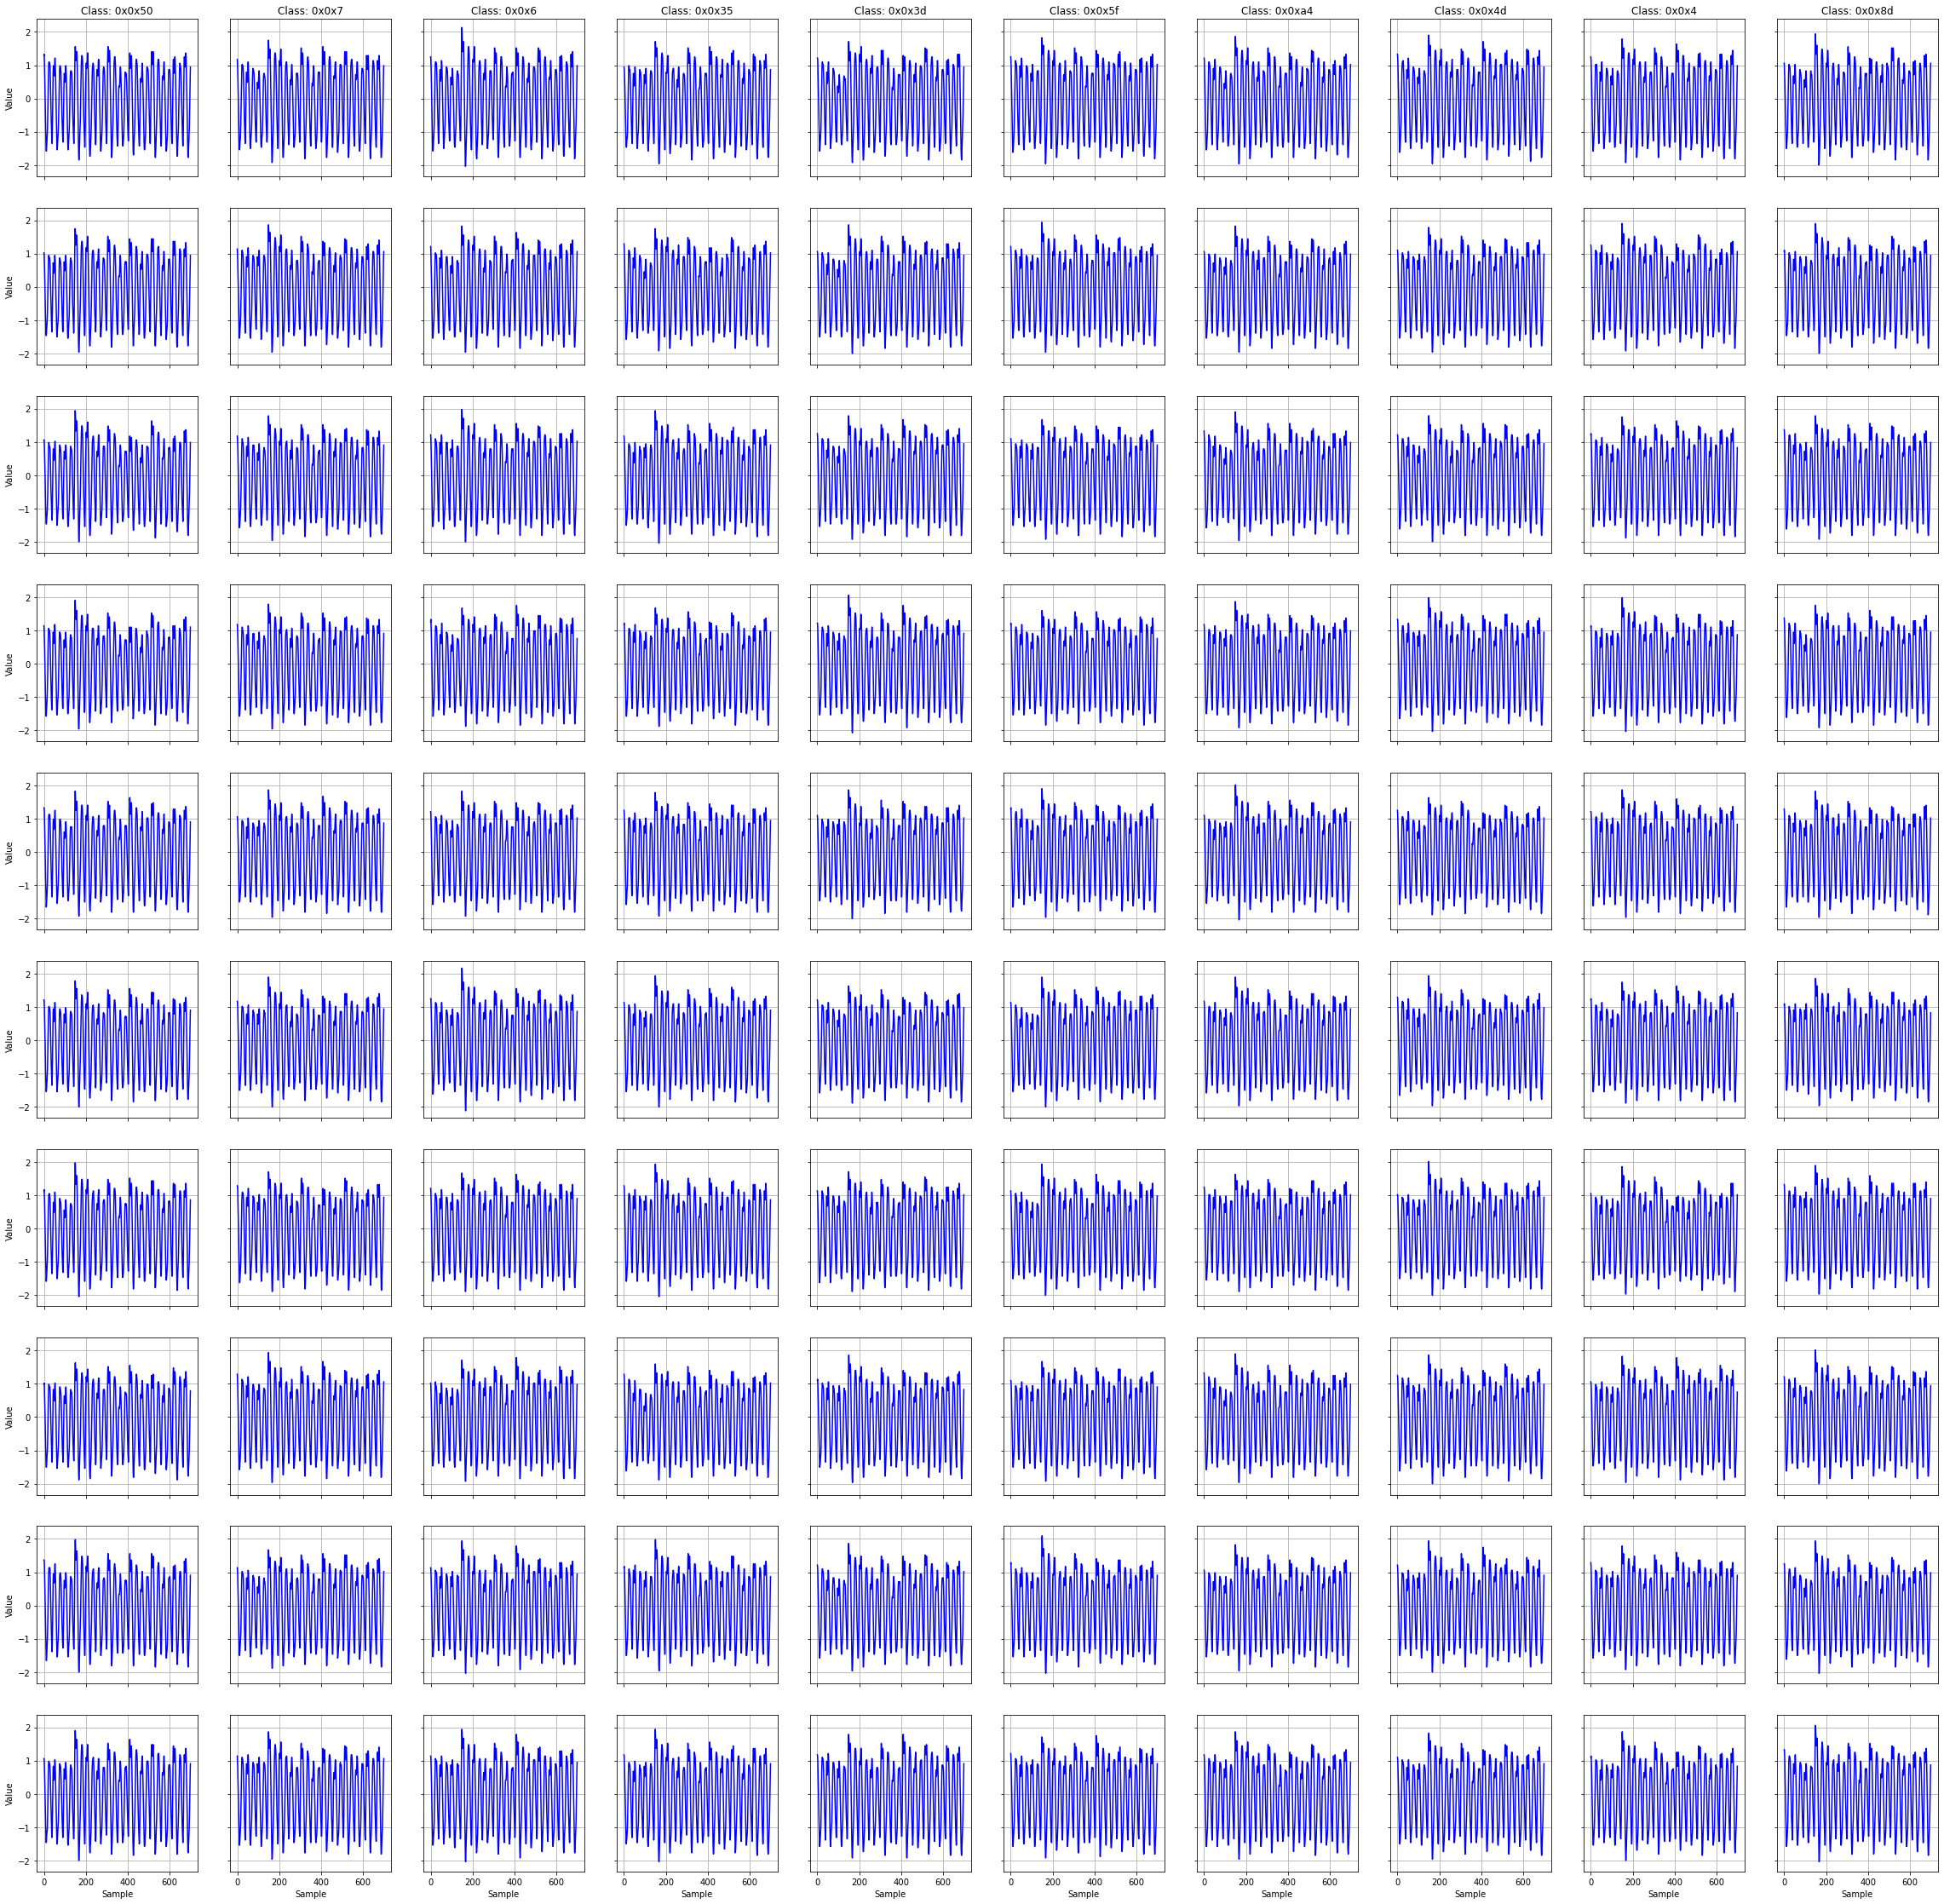

In [4]:
(fig, ax), displayed_indices = show_dataset(test_dataset)

In [5]:
def get_discriminator():
    return resnet18().to(device)
    #return BenadjilaBest(input_shape=train_dataset.trace_shape, output_shape=(train_dataset.num_classes,)).to(device)
def get_generator():
    return LstmModel().to(device)
discriminator = get_discriminator()
generator = get_generator()
disc_opt = optim.RMSprop(discriminator.parameters(), lr=5e-5)
gen_opt = optim.Adam(generator.parameters(), lr=2e-4)

class MaskLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce_loss_fn = nn.BCELoss()
        self.sigmoid_fn = nn.Sigmoid()
    def forward(self, logits, target):
        loss = self.bce_loss_fn(self.sigmoid_fn(logits), self.sigmoid_fn(target))
        return loss
class PredLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.ce_loss_fn = nn.CrossEntropyLoss()
    def forward(self, logits, target):
        loss = self.ce_loss_fn(logits, target)
        return loss
mask_loss_fn = MaskLoss()
pred_loss_fn = PredLoss()
disc_loss_fn = nn.CrossEntropyLoss()

print('Generator:')
print(generator)
print(gen_opt)
print(mask_loss_fn)
print(pred_loss_fn)

Generator:
LstmModel(
  (encoder): ModuleList(
    (0): GRUCell(1, 256)
  )
  (mask_decoder): ModuleList(
    (0): GRUCell(256, 256)
    (1): Linear(in_features=256, out_features=1, bias=True)
  )
  (pred_decoder): ModuleList(
    (0): GRUCell(256, 256)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)
MaskLoss(
  (bce_loss_fn): BCELoss()
  (sigmoid_fn): Sigmoid()
)
PredLoss(
  (ce_loss_fn): CrossEntropyLoss()
)


### Pretrain discriminator

In [6]:
def train_epoch(idx, train=True):
    if train:
        results = execute_epoch(train_step, train_dataloader,
                                discriminator, disc_loss, disc_opt, device)
    else:
        results = execute_epoch(eval_step, train_dataloader,
                                discriminator, disc_loss, device)
    with open(os.path.join(results_path, 'disc_pretrain__train_epoch_%d.pickle'%(idx)), 'wb') as F:
        pickle.dump(results, F)
def eval_epoch(idx):
    global min_rank, best_discriminator, best_disc_opt
    results = execute_epoch(eval_step, test_dataloader,
                            discriminator, disc_loss, device)
    rank = np.mean(results['mean_rank'])
    if rank < min_rank:
        min_rank = rank
        best_discriminator = deepcopy(discriminator.state_dict())
        best_disc_optim = deepcopy(disc_opt.state_dict())
    with open(os.path.join(results_path, 'disc_pretrain__eval_epoch_%d.pickle'%(idx)), 'wb') as F:
        pickle.dump(results, F)

if retrain_disc:
    min_rank = np.inf
    best_discriminator = None
    best_disc_opt = None
    progress_bar = tqdm(total=disc_pretrain_epochs+1)
    train_epoch(0, train=False)
    eval_epoch(0)
    progress_bar.update(1)
    for epoch in range(1, disc_pretrain_epochs+1):
        train_epoch(epoch)
        eval_epoch(epoch)
        progress_bar.update(1)
    torch.save(best_discriminator, os.path.join(results_path, 'pretrained_discriminator'))
    torch.save(best_disc_opt, os.path.join(results_path, 'pretrained_discriminator_optimizer'))

### Pretrain generator

In [7]:
def train_epoch(idx, train=True):
    if train:
        results = execute_epoch(lstm_train_step, train_dataloader,
                                generator, mask_loss_fn, pred_loss_fn, gen_opt, device, grad_clip=1.0)
    else:
        results = execute_epoch(lstm_eval_step, train_dataloader,
                                generator, mask_loss_fn, pred_loss_fn, device)
    with open(os.path.join(results_path, 'gen_pretrain__train_epoch_%d.pickle'%(idx)), 'wb') as F:
        pickle.dump(results, F)
def eval_epoch(idx):
    global min_loss, best_generator, best_gen_opt
    results = execute_epoch(lstm_eval_step, test_dataloader,
                            generator, mask_loss_fn, pred_loss_fn, device)
    loss = np.mean(results['mask_loss'])
    if loss < min_loss:
        min_loss = loss
        best_generator = deepcopy(generator.state_dict())
        best_gen_optim = deepcopy(gen_opt.state_dict())
    with open(os.path.join(results_path, 'gen_pretrain__eval_epoch_%d.pickle'%(idx)), 'wb') as F:
        pickle.dump(results, F)

if retrain_gen:
    min_loss = np.inf
    best_generator = None
    best_gen_optim = None
    progress_bar = tqdm(total=gen_pretrain_epochs+1)
    train_epoch(0, train=False)
    eval_epoch(0)
    progress_bar.update(1)
    for epoch in range(1, gen_pretrain_epochs+1):
        train_epoch(epoch)
        eval_epoch(epoch)
        progress_bar.update(1)
    torch.save(best_generator, os.path.join(results_path, 'pretrained_generator'))
    torch.save(best_gen_optim, os.path.join(results_path, 'pretrained_generator_optimizer'))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [1:00:29<00:00, 344.66s/it]

discriminator = get_discriminator()
generator = get_generator()
discriminator.load_state_dict(torch.load(os.path.join(results_path, 'pretrained_discriminator')))
generator.load_state_dict(torch.load(os.path.join(results_path, 'pretrained_generator')))

/local/scratch/a/jgammell/sca_defense/display_results.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  trace = np.array(trace)[indices]
/local/scratch/a/jgammell/sca_defense/display_results.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  trace = np.array(trace)[indices]
/local/scratch/a/jgammell/sca_defense/display_results.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must s

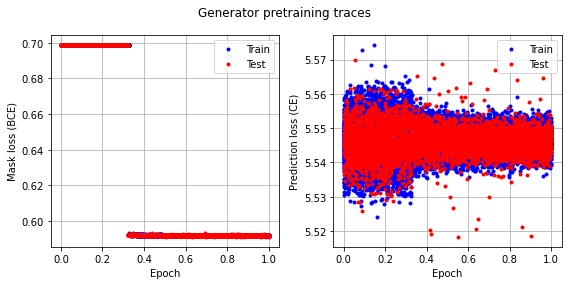

In [8]:
fig, axes = plot_traces(results_path, 'gen_pretrain', ['mask_loss', 'pred_loss'])
axes[0].set_ylabel('Mask loss (BCE)')
axes[1].set_ylabel('Prediction loss (CE)')
fig.suptitle('Generator pretraining traces')
plt.tight_layout()

In [9]:
fig, axes = plot_traces(results_path, 'disc_pretrain', ['loss', 'acc', 'mean_rank'])
axes[0].set_ylabel('Cross entropy loss')
axes[1].set_ylabel('Accuracy')
axes[2].set_ylabel('Mean rank')
fig.suptitle('Discriminator pretraining curves')
plt.tight_layout()

AssertionError: 

In [ ]:
disc_opt = optim.RMSprop(discriminator.parameters(), lr=1e-5)
gen_opt = optim.RMSprop(generator.parameters(), lr=1e-5)

def train_epoch(idx, train=True):
    if train:
        results = execute_epoch(adversarial_train_step, train_dataloader,
                                discriminator, disc_loss, disc_opt,
                                generator, gen_loss, gen_opt, device)
    else:
        results = execute_epoch(adversarial_eval_step, train_dataloader,
                                discriminator, disc_loss, generator, gen_loss, device)
    with open(os.path.join(results_path, 'adversarial__train_epoch_%d.pickle'%(idx)), 'wb') as F:
        pickle.dump(results, F)
def eval_epoch(idx):
    global min_rank, best_discriminator, best_disc_opt
    results = execute_epoch(adversarial_eval_step, test_dataloader,
                            discriminator, disc_loss, generator, gen_loss, device)
    with open(os.path.join(results_path, 'adversarial__eval_epoch_%d.pickle'%(idx)), 'wb') as F:
        pickle.dump(results, F)

if retrain_adversarial:
    progress_bar = tqdm(total=adversarial_train_epochs+1)
    train_epoch(0, train=False)
    eval_epoch(0)
    progress_bar.update(1)
    for epoch in range(1, adversarial_train_epochs+1):
        train_epoch(epoch)
        eval_epoch(epoch)
        progress_bar.update(1)

In [ ]:
torch.save(discriminator, os.path.join(results_path, 'adversarial_discriminator'))
torch.save(disc_opt, os.path.join(results_path, 'adversarial_discriminator_optimizer'))
torch.save(generator, os.path.join(results_path, 'adversarial_generator'))
torch.save(gen_opt, os.path.join(results_path, 'adversarial_generator_optimizer'))

In [ ]:
fig, axes = plot_traces(results_path, 'adversarial', ['gen_loss'])
axes[0].set_ylabel('Loss')
fig.suptitle('Generator adversarial traces')

In [ ]:
fig, axes = plot_traces(results_path, 'adversarial', ['disc_loss', 'disc_acc', 'disc_mean_rank'])
axes[0].set_ylabel('Loss')
axes[1].set_ylabel('Accuracy')
axes[2].set_ylabel('Mean rank')
fig.suptitle('Discriminator adversarial traces')
plt.tight_layout()